In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import soundfile
import numpy as np
import librosa
import glob
import os
from sklearn.model_selection import train_test_split


In [4]:
def extract_feature(file_name, **kwargs):
    """
    Extract features from an audio file.
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        Example:
            `features = extract_feature(path, mel=True, mfcc=True)`
    """
    # Feature flags
    mfcc = kwargs.get("mfcc", False)
    chroma = kwargs.get("chroma", False)
    mel = kwargs.get("mel", False)
    contrast = kwargs.get("contrast", False)
    tonnetz = kwargs.get("tonnetz", False)

    try:
        # Load audio file
        with soundfile.SoundFile(file_name) as sound_file:
            X = sound_file.read(dtype="float32")
            sample_rate = sound_file.samplerate

        # Initialize result array
        result = np.array([])

        # Short-time Fourier transform for chroma and contrast
        stft = np.abs(librosa.stft(X)) if chroma or contrast else None

        # Extract features
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma and stft is not None:
            chroma_features = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma_features))
        if mel:
            mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel_spectrogram))
        if contrast and stft is not None:
            contrast_features = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, contrast_features))
        if tonnetz:
            tonnetz_features = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
            result = np.hstack((result, tonnetz_features))

        return result

    except Exception as e:
        print(f"Error extracting features from {file_name}: {e}")
        return None

In [5]:
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(test_size=0.2):
    # Updated int2emotion mapping for SAVEE dataset
    int2emotion = {
        "a": 0,  # angry
        "h": 1,  # happy
        "n": 2,  # neutral
        "s": 3  # sad
    }

    # List of emotions to include
    AVAILABLE_EMOTIONS = {"a", "h", "n", "s"}

    X, y = [], []
    # Adjust the path to point to your SAVEE dataset location
    files = glob.glob("/content/drive/My Drive/SAVEE/*.wav")
    print(f"Found {len(files)} audio files.")

    if not files:
        raise ValueError("No audio files found in the specified directory.")

    for file in files:
        try:
            # Skip files with '_su' in the name
            if '_su' in os.path.basename(file):
                print(f"Skipping file: {file} (contains '_su' in filename)")
                continue

            # Rename files with '_sa' to '_s'
            basename = os.path.basename(file)
            if '_sa' in basename:
                new_basename = basename.replace('_sa', '_s')
                new_file = os.path.join(os.path.dirname(file), new_basename)
                os.rename(file, new_file)
                file = new_file  # Update the file path to the new name
                print(f"Renamed file: {basename} to {new_basename}")

            # Extract the emotion label from the filename
            # Example SAVEE filename format: "DC_s01.wav" or "DC_a01.wav"
            emotion_key = basename.split("_")[1][:1]  # Take the first two characters of the second segment
            emotion = int2emotion.get(emotion_key, None)

            if emotion is None:
                print(f"Skipping file: {basename} (emotion '{emotion_key}' not found)")
                continue

            if emotion_key not in AVAILABLE_EMOTIONS:
                print(f"Skipping file: {basename} (emotion '{emotion_key}' not in AVAILABLE_EMOTIONS)")
                continue

            # Extract features from the audio file
            features = extract_feature(file, mfcc=True, chroma=True, mel=True)

            if features is None or not isinstance(features, np.ndarray):
                print(f"Skipping file: {basename} (feature extraction failed)")
                continue

            # Add features and emotion to the data
            X.append(features)
            y.append(emotion)

        except Exception as e:
            print(f"Error processing file {file}: {e}")

    print(f"Total valid samples collected: {len(X)}")
    if len(X) == 0:
        raise ValueError("No valid samples collected. Check the emotion labels and feature extraction.")

    # Use stratified splitting to ensure that each class is represented proportionally in the train and test sets
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7, stratify=y)



In [6]:
X_train, X_test, y_train, y_test = load_data(test_size=0.25)
# print some details
# number of samples in training data
print("[+] Number of training samples:", X_train.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])
# number of features used
# this is a vector of features extracted
# using utils.extract_features() method
print("[+] Number of features:", X_train.shape[1])

Found 496 audio files.
Skipping file: DC_f01.wav (emotion 'f' not found)
Skipping file: DC_f15.wav (emotion 'f' not found)
Skipping file: DC_d06.wav (emotion 'd' not found)
Skipping file: DC_f05.wav (emotion 'f' not found)
Skipping file: DC_d01.wav (emotion 'd' not found)
Skipping file: DC_d02.wav (emotion 'd' not found)
Skipping file: DC_d13.wav (emotion 'd' not found)
Skipping file: DC_d11.wav (emotion 'd' not found)
Skipping file: DC_d07.wav (emotion 'd' not found)
Skipping file: DC_f13.wav (emotion 'f' not found)
Skipping file: DC_d03.wav (emotion 'd' not found)
Skipping file: DC_d04.wav (emotion 'd' not found)
Skipping file: DC_d05.wav (emotion 'd' not found)
Skipping file: DC_f11.wav (emotion 'f' not found)
Skipping file: DC_d15.wav (emotion 'd' not found)
Skipping file: DC_f06.wav (emotion 'f' not found)
Skipping file: DC_f12.wav (emotion 'f' not found)
Skipping file: DC_d14.wav (emotion 'd' not found)
Skipping file: DC_f10.wav (emotion 'f' not found)
Skipping file: DC_f03.wav (


Accuracy: 0.65
Precision: 0.64
Recall: 0.65
F1 Score: 0.62
AUC-ROC Score: 0.79


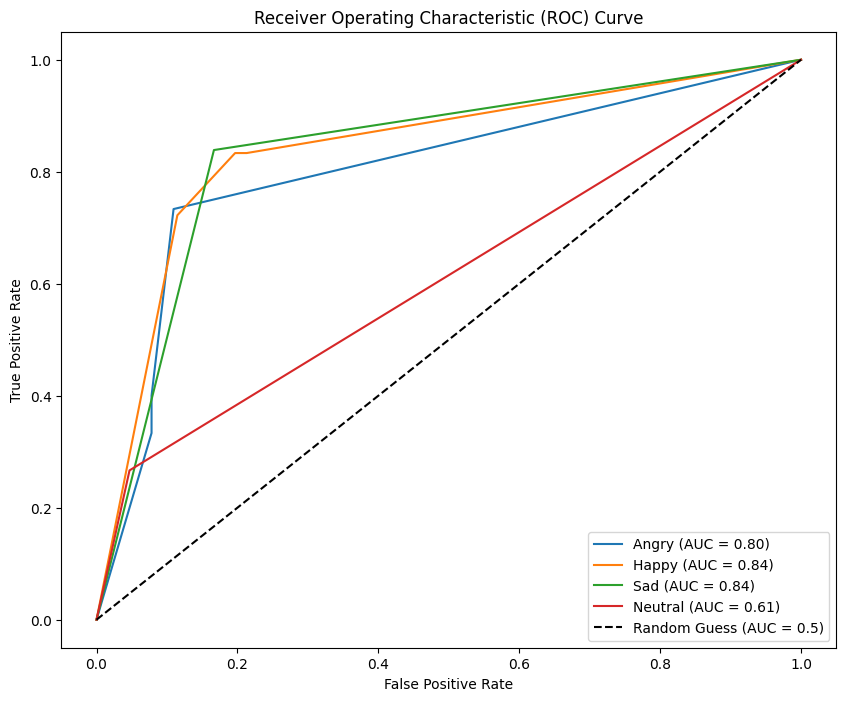

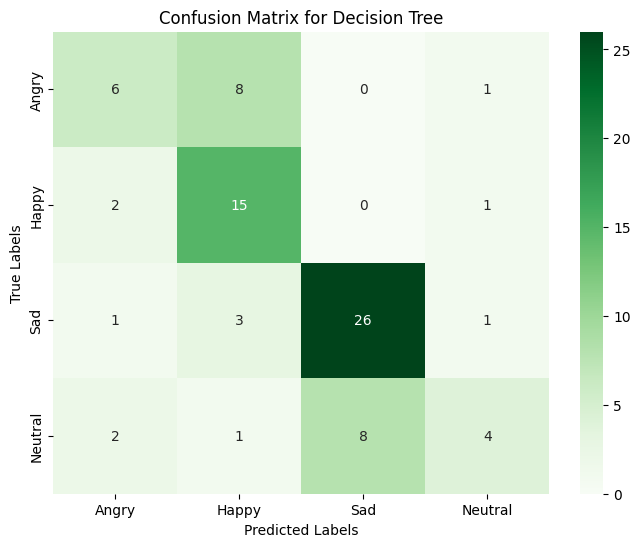

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Create and train the Decision Tree classifier directly
dtree = DecisionTreeClassifier(max_depth=5, min_samples_split=2, min_samples_leaf=1)  # Example of parameters

# Fit the model to the training data
dtree.fit(X_train, y_train)

# Make predictions on the test set
dtree_predictions = dtree.predict(X_test)

# Calculate the metrics
accuracy = accuracy_score(y_test, dtree_predictions)
precision = precision_score(y_test, dtree_predictions, average='weighted')
recall = recall_score(y_test, dtree_predictions, average='weighted')
f1 = f1_score(y_test, dtree_predictions, average='weighted')

# For multi-class classification, calculate AUC-ROC
auc_roc = roc_auc_score(y_test, dtree.predict_proba(X_test), multi_class='ovr', average='weighted')

# Output the results
print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")

# Binarize the labels for ROC curve plotting
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Adjust the classes if needed
n_classes = y_test_bin.shape[1]

# Emotion labels (assuming your classes are these)
emotion_labels = {0: 'Angry', 1: 'Happy', 2: 'Sad', 3: 'Neutral'}

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], dtree.predict_proba(X_test)[:, i])
    auc_score = roc_auc_score(y_test_bin[:, i], dtree.predict_proba(X_test)[:, i])
    plt.plot(fpr_i, tpr_i, label=f'{emotion_labels[i]} (AUC = {auc_score:.2f})')

# Plotting the random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')

# Labels and title for the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
conf_matrix_dt = confusion_matrix(y_test, dtree_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", cmap="Greens", xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Decision Tree')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Accuracy: 0.58
Precision: 0.55
Recall: 0.58
F1 Score: 0.48
AUC-ROC Score: 0.78


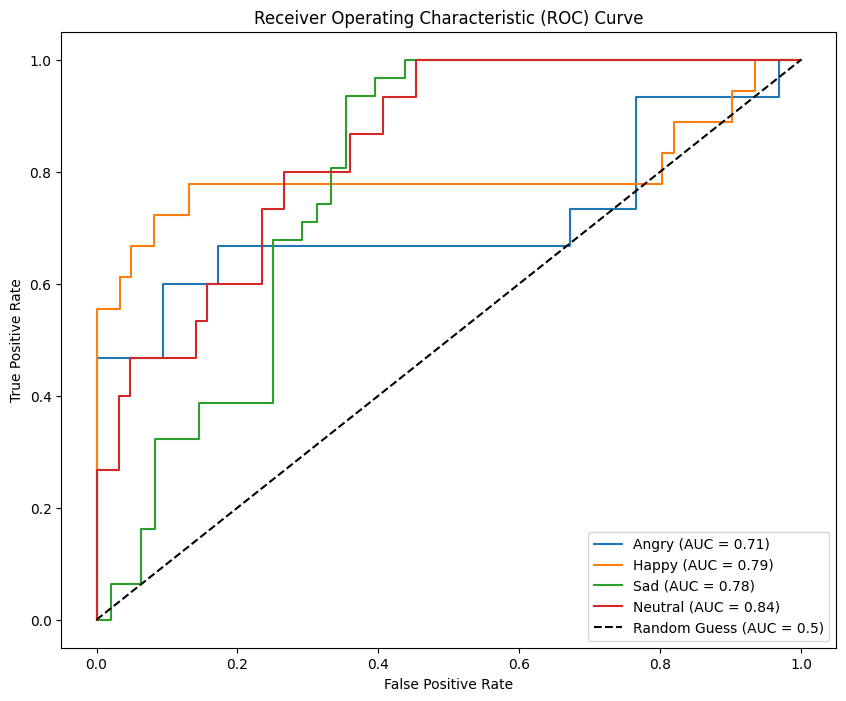

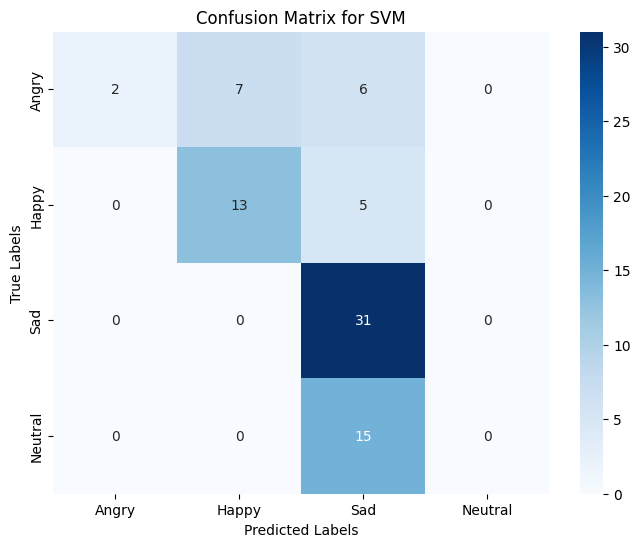

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the SVM model with chosen hyperparameters
svc = SVC(C=1, kernel='rbf', gamma='scale', degree=3, probability=True)  # Example parameters

# Train the model
svc.fit(X_train, y_train)

# Make predictions on the test set
svm_predictions = svc.predict(X_test)

# Calculate the metrics
accuracy = accuracy_score(y_test, svm_predictions)
precision = precision_score(y_test, svm_predictions, average='weighted')
recall = recall_score(y_test, svm_predictions, average='weighted')
f1 = f1_score(y_test, svm_predictions, average='weighted')

# For multi-class classification, calculate AUC-ROC
auc_roc = roc_auc_score(y_test, svc.predict_proba(X_test), multi_class='ovr', average='weighted')

# Output the results
print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")

# Binarize the labels for ROC curve plotting
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Adjust the classes if needed
n_classes = y_test_bin.shape[1]

# Emotion labels (assuming your classes are these)
emotion_labels = {0: 'Angry', 1: 'Happy', 2: 'Sad', 3: 'Neutral'}

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], svc.predict_proba(X_test)[:, i])
    auc_score = auc(fpr_i, tpr_i)
    plt.plot(fpr_i, tpr_i, label=f'{emotion_labels[i]} (AUC = {auc_score:.2f})')

# Plotting the random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')

# Labels and title for the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
conf_matrix_svc = confusion_matrix(y_test, svm_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svc, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM')
plt.show()




Accuracy: 0.86
Precision: 0.88
Recall: 0.86
F1 Score: 0.85
AUC-ROC Score: 0.97


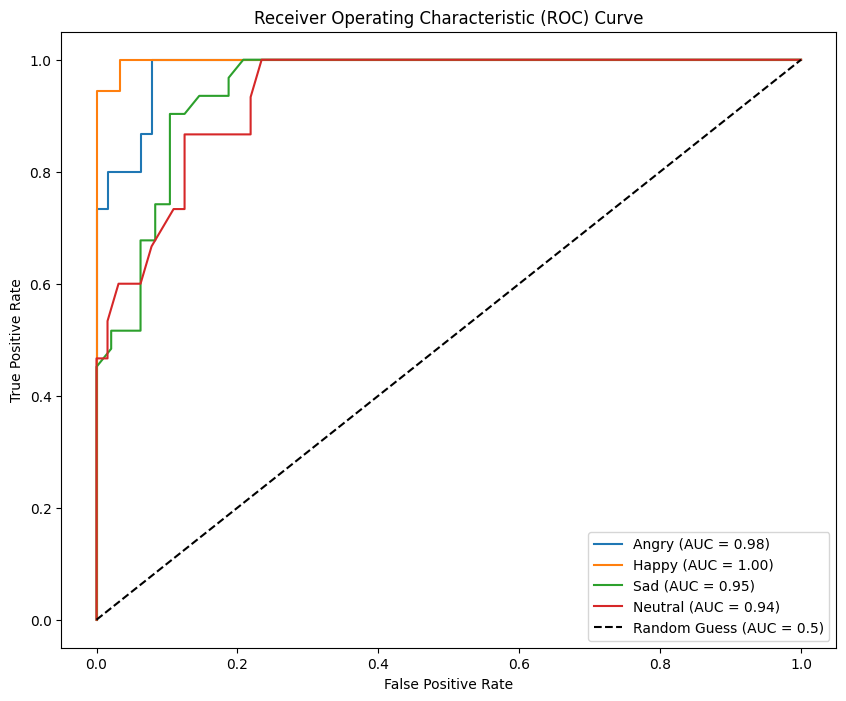

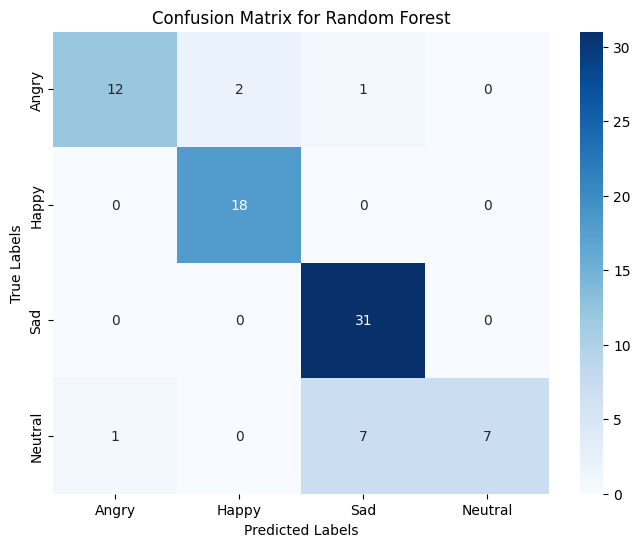

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the RandomForestClassifier with chosen hyperparameters
rf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1, bootstrap=True, random_state=0)

# Train the model
rf.fit(X_train, y_train)

# Make predictions on the test set
rf_predictions = rf.predict(X_test)

# Calculate the metrics
accuracy = accuracy_score(y_test, rf_predictions)
precision = precision_score(y_test, rf_predictions, average='weighted')
recall = recall_score(y_test, rf_predictions, average='weighted')
f1 = f1_score(y_test, rf_predictions, average='weighted')

# For multi-class classification, calculate AUC-ROC
auc_roc = roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr', average='weighted')

# Output the results
print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")

# Binarize the labels for ROC curve plotting
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Adjust the classes if needed
n_classes = y_test_bin.shape[1]

# Emotion labels (assuming your classes are these)
emotion_labels = {0: 'Angry', 1: 'Happy', 2: 'Sad', 3: 'Neutral'}

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], rf.predict_proba(X_test)[:, i])
    auc_score = auc(fpr_i, tpr_i)
    plt.plot(fpr_i, tpr_i, label=f'{emotion_labels[i]} (AUC = {auc_score:.2f})')

# Plotting the random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')

# Labels and title for the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, rf_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()


[Naive Bayes] Accuracy: 0.62

Precision: 0.67
Recall: 0.62
F1 Score: 0.59
AUC-ROC Score: 0.83


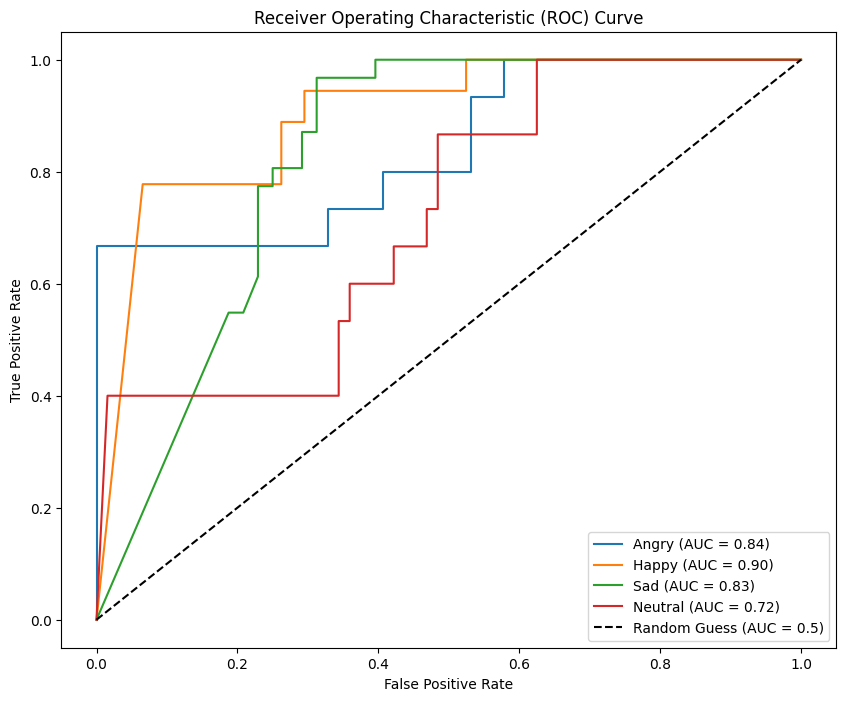

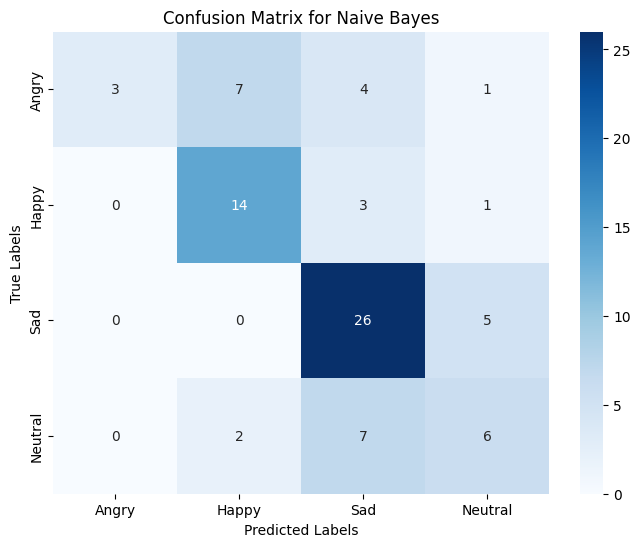

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

# Make predictions
nb_predictions = nb_classifier.predict(X_test)

# Calculate the metrics
accuracy = accuracy_score(y_test, nb_predictions)
precision = precision_score(y_test, nb_predictions, average='weighted')
recall = recall_score(y_test, nb_predictions, average='weighted')
f1 = f1_score(y_test, nb_predictions, average='weighted')

# For multi-class classification, calculate AUC-ROC
auc_roc = roc_auc_score(y_test, nb_classifier.predict_proba(X_test), multi_class='ovr', average='weighted')

# Output the results
print(f"[Naive Bayes] Accuracy: {accuracy:.2f}")
print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")

# Binarize the labels for ROC curve plotting
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Adjust the classes if needed
n_classes = y_test_bin.shape[1]

# Emotion labels (assuming your classes are these)
emotion_labels = {0: 'Angry', 1: 'Happy', 2: 'Sad', 3: 'Neutral'}

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], nb_classifier.predict_proba(X_test)[:, i])
    auc_score = auc(fpr_i, tpr_i)
    plt.plot(fpr_i, tpr_i, label=f'{emotion_labels[i]} (AUC = {auc_score:.2f})')

# Plotting the random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')

# Labels and title for the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
conf_matrix_nb = confusion_matrix(y_test, nb_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()


[KNN] Accuracy: 0.76

Precision: 0.77
Recall: 0.76
F1 Score: 0.76
AUC-ROC Score: 0.94


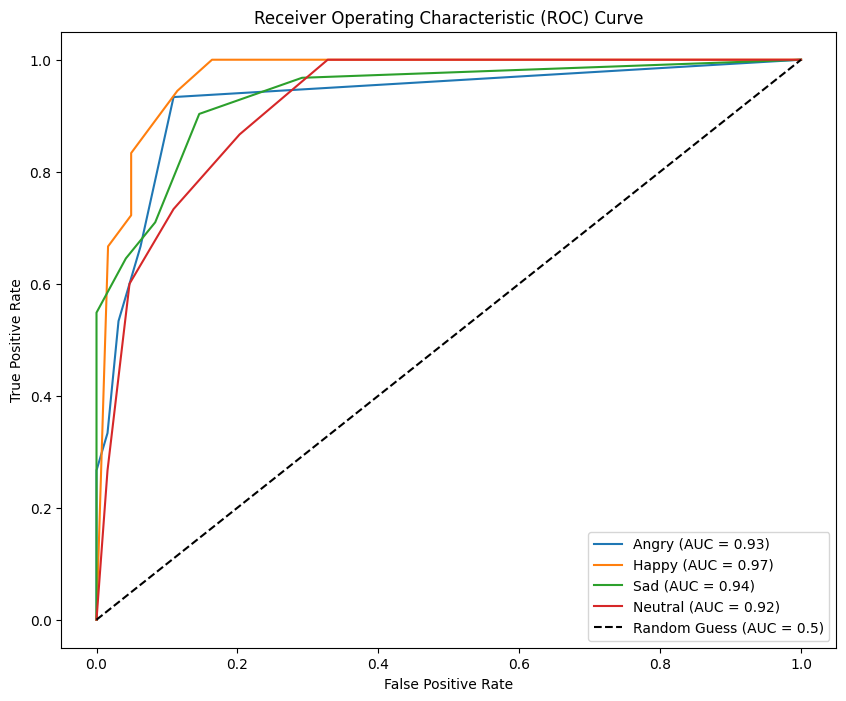

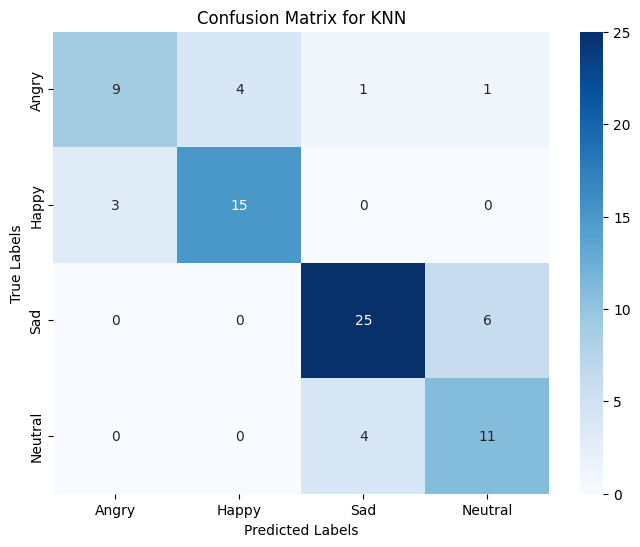

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the KNN classifier with chosen hyperparameters
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')  # Example parameters

# Train the classifier
knn.fit(X_train_scaled, y_train)

# Make predictions on the test set
knn_predictions = knn.predict(X_test_scaled)

# Calculate the metrics
accuracy = accuracy_score(y_test, knn_predictions)
precision = precision_score(y_test, knn_predictions, average='weighted')
recall = recall_score(y_test, knn_predictions, average='weighted')
f1 = f1_score(y_test, knn_predictions, average='weighted')

# For multi-class classification, calculate AUC-ROC
auc_roc = roc_auc_score(y_test, knn.predict_proba(X_test_scaled), multi_class='ovr', average='weighted')

# Output the results
print(f"[KNN] Accuracy: {accuracy:.2f}")
print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")

# Binarize the labels for ROC curve plotting
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Adjust the classes if needed
n_classes = y_test_bin.shape[1]

# Emotion labels (assuming your classes are these)
emotion_labels = {0: 'Angry', 1: 'Happy', 2: 'Sad', 3: 'Neutral'}

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], knn.predict_proba(X_test_scaled)[:, i])
    auc_score = auc(fpr_i, tpr_i)
    plt.plot(fpr_i, tpr_i, label=f'{emotion_labels[i]} (AUC = {auc_score:.2f})')

# Plotting the random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')

# Labels and title for the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
conf_matrix_knn = confusion_matrix(y_test, knn_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for KNN')
plt.show()


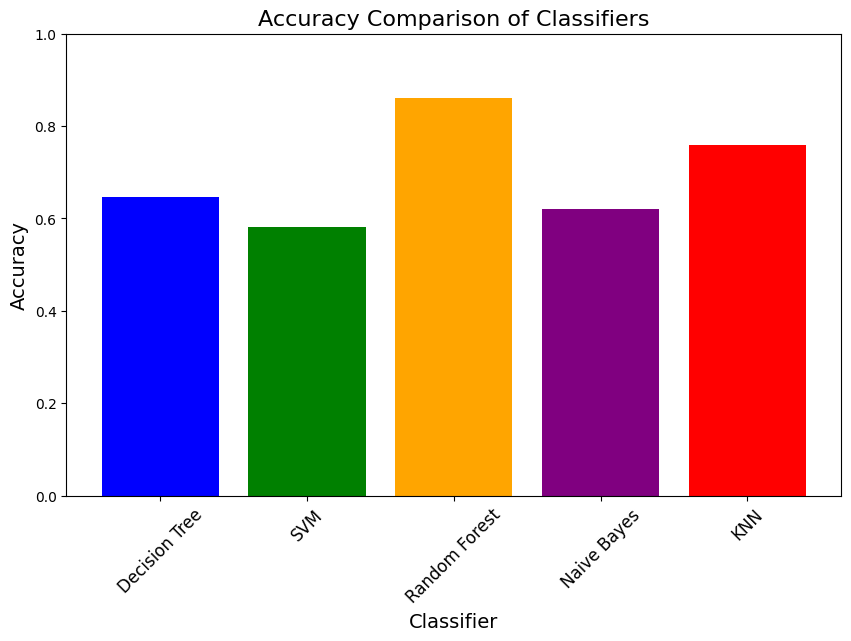

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy scores from all classifiers
results = {
    'Decision Tree': accuracy_score(y_test, dtree_predictions),
    'SVM': accuracy_score(y_test, svm_predictions),
    'Random Forest': accuracy_score(y_test, rf_predictions),
    'Naive Bayes': accuracy_score(y_test, nb_predictions),
    'KNN': accuracy_score(y_test, knn_predictions)
}

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'orange', 'purple', 'red'])
plt.title('Accuracy Comparison of Classifiers', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Classifier', fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=45, fontsize=12)
plt.show()


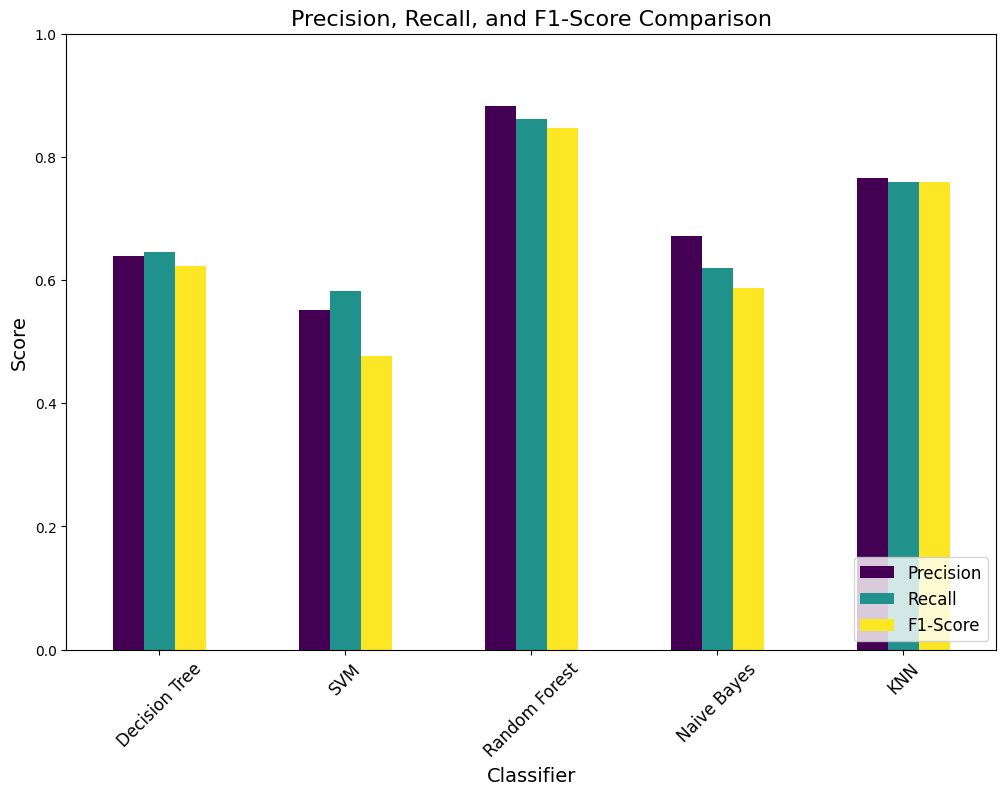

In [18]:
from sklearn.metrics import precision_recall_fscore_support

# Extract precision, recall, and F1-score
metrics = {}
for name, preds in zip(['Decision Tree', 'SVM', 'Random Forest', 'Naive Bayes', 'KNN'],
                       [dtree_predictions, svm_predictions,  rf_predictions, nb_predictions, knn_predictions]):
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='weighted', zero_division=0)
    metrics[name] = {'Precision': precision, 'Recall': recall, 'F1-Score': f1}

# Convert to DataFrame for plotting
import pandas as pd
metrics_df = pd.DataFrame(metrics).T

# Plot
metrics_df.plot(kind='bar', figsize=(12, 8), colormap='viridis')
plt.title('Precision, Recall, and F1-Score Comparison', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Classifier', fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=45, fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.show()
